 In this task we have to develop a machine learning model to predict two key parameter 
 1-infinite multipication factor 
 2-pin power peaking factor

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

The dataset downloaded was confusing.It had issues like no header to denote outputs inputs and rows were in a single box.
I cleaned the dataset and converted it in proper Tabular form to use it in padas

In [28]:
data=pd.read_csv(r"C:\Users\sujal\Desktop\lattice\Raw.csv",header =None)

After loading the data now main issue was to find the two output column and 39 features.
I figured out through a research paper which had got in the dataset website , i will give the link of paper below. 

Both outputs will have gaussian distribution and features will have random.


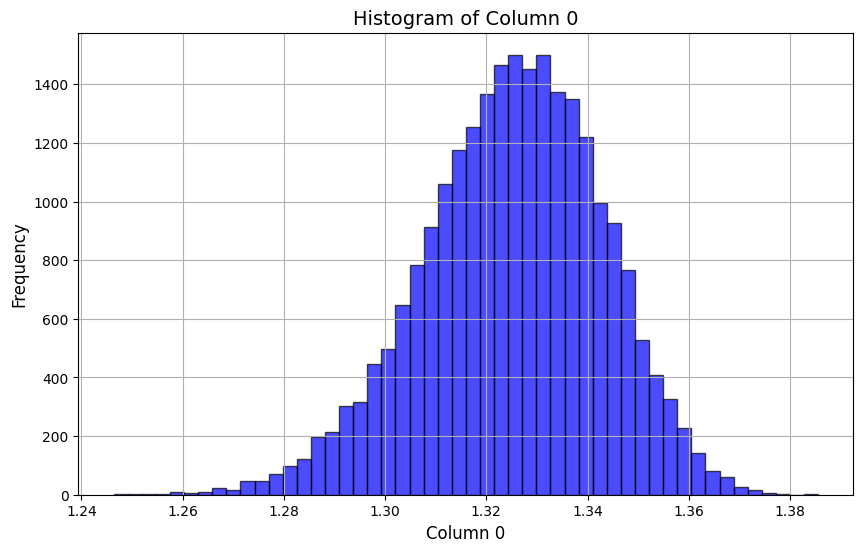

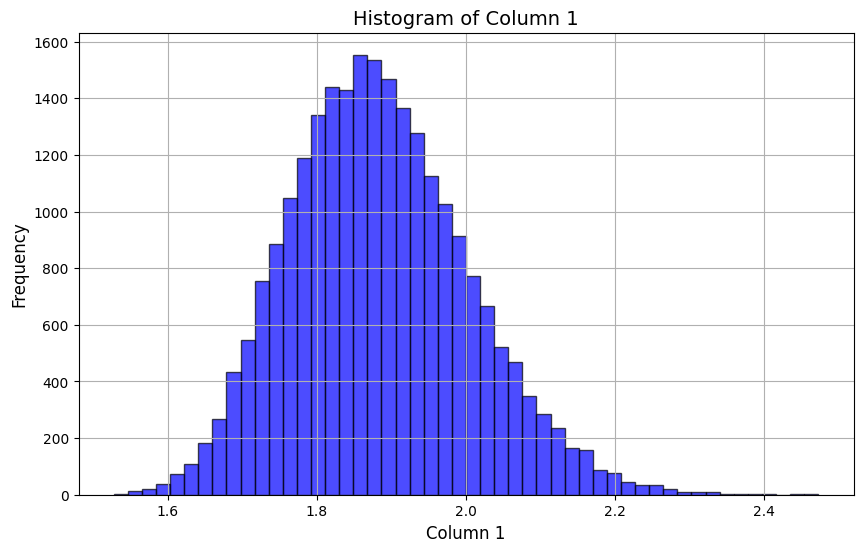

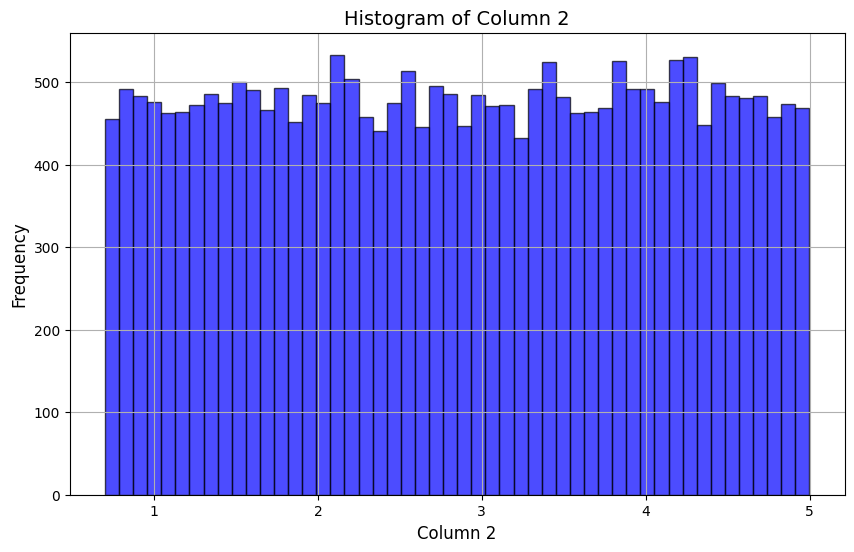

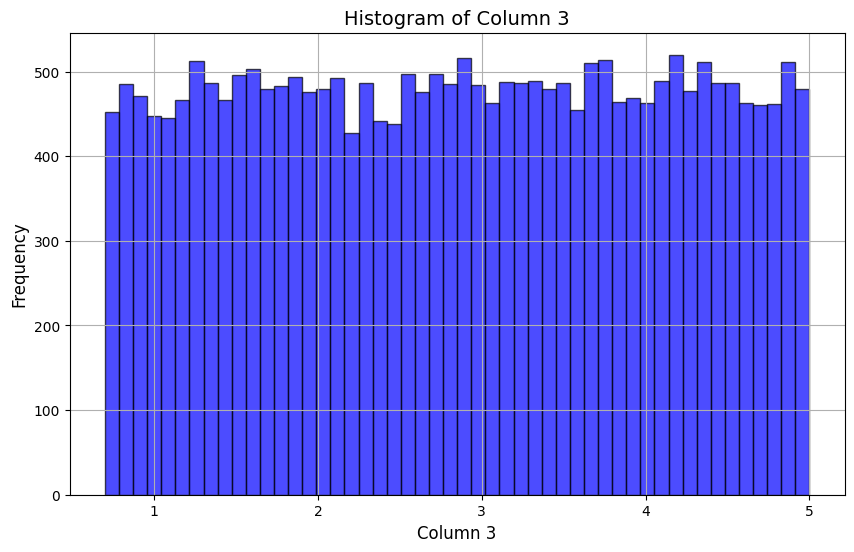

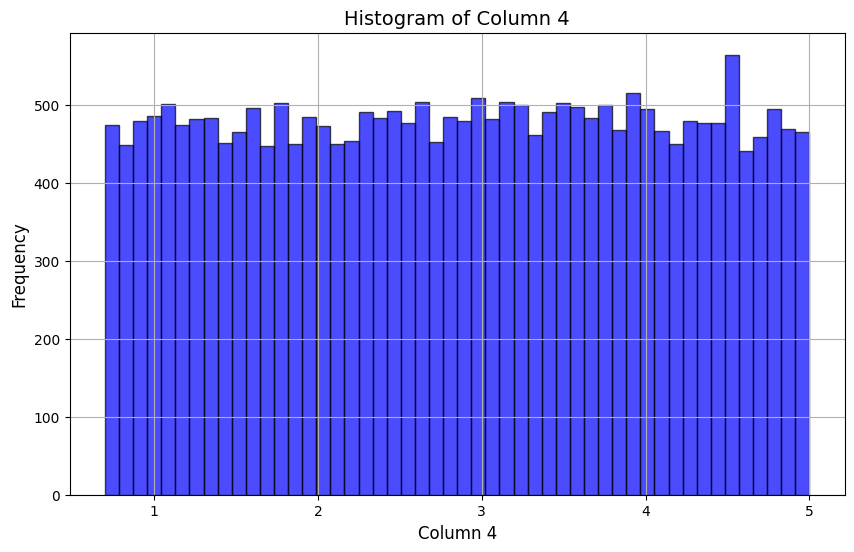

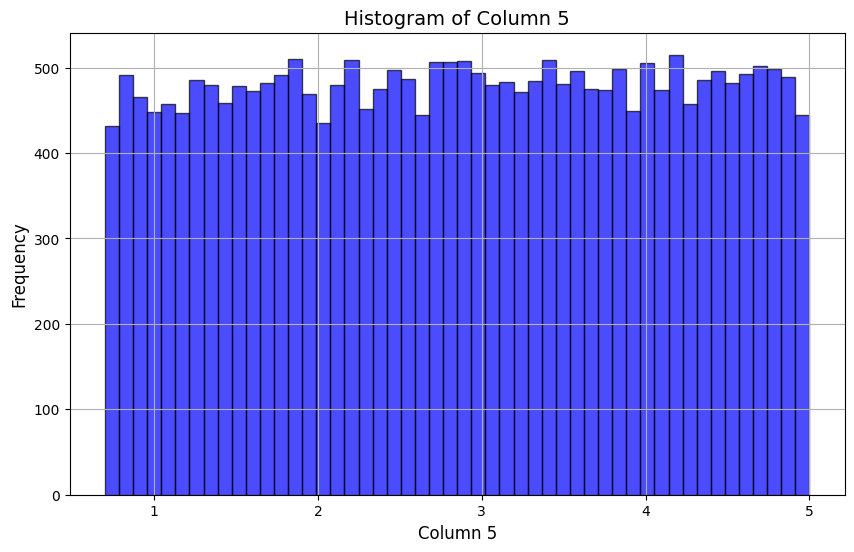

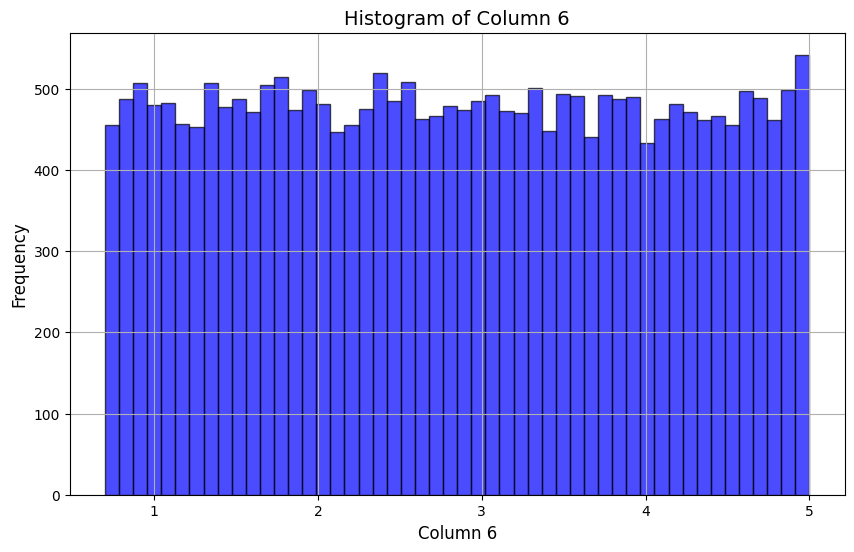

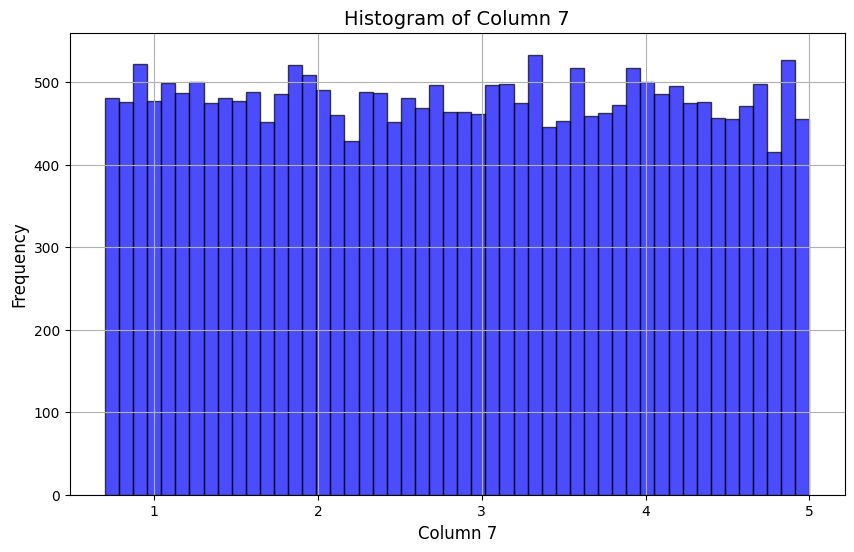

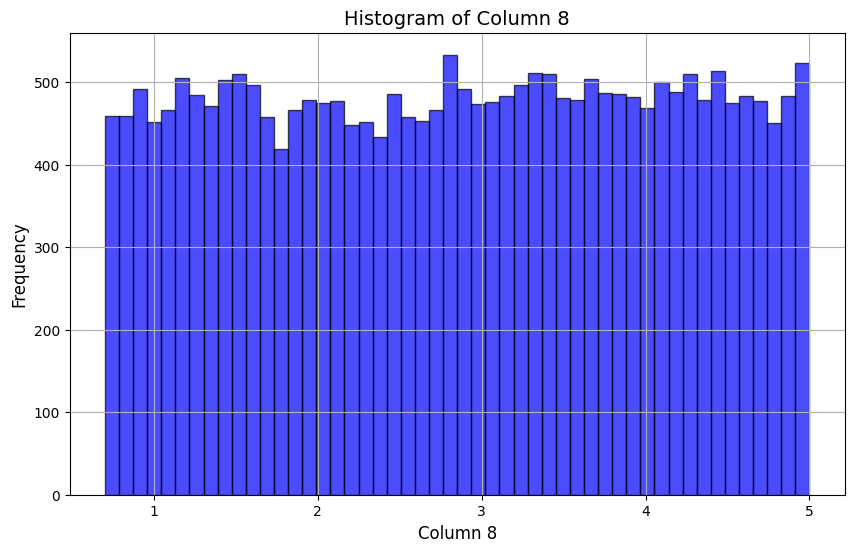

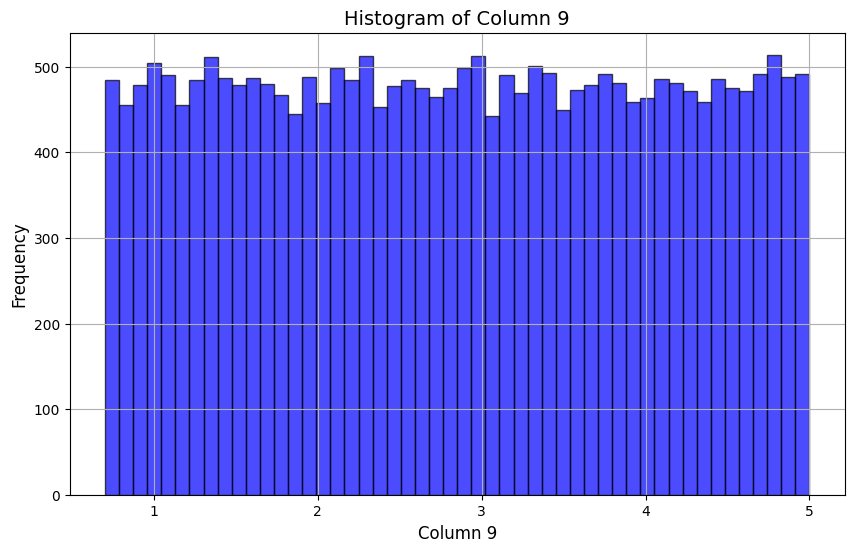

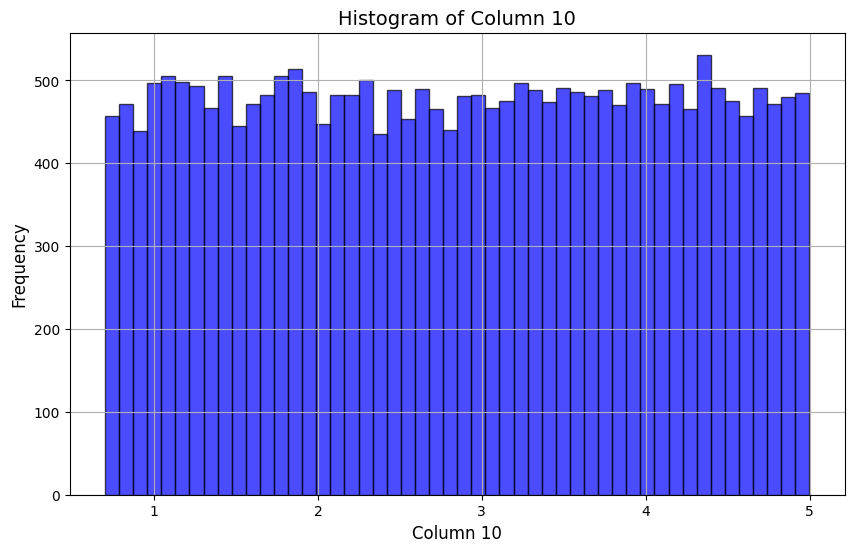

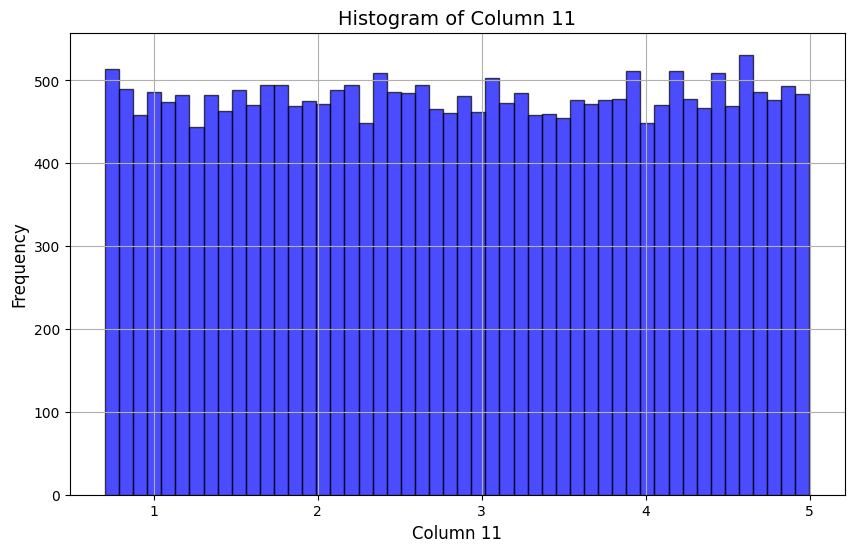

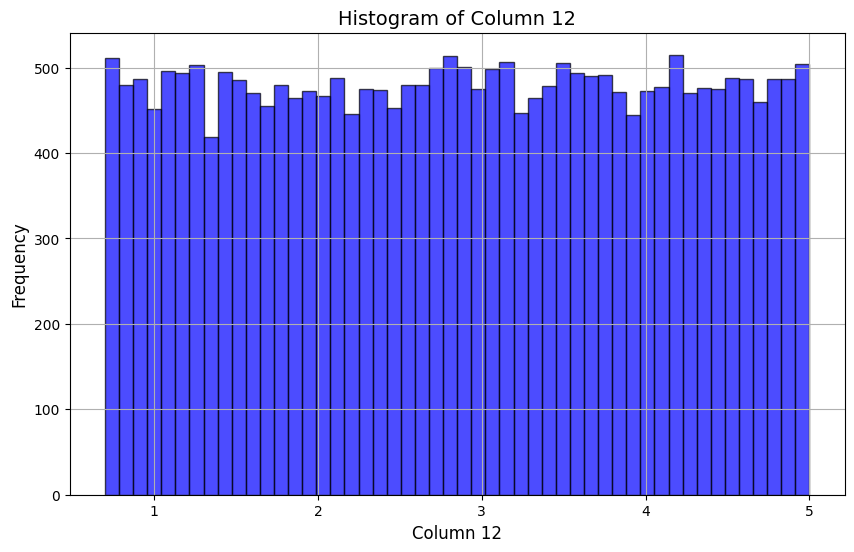

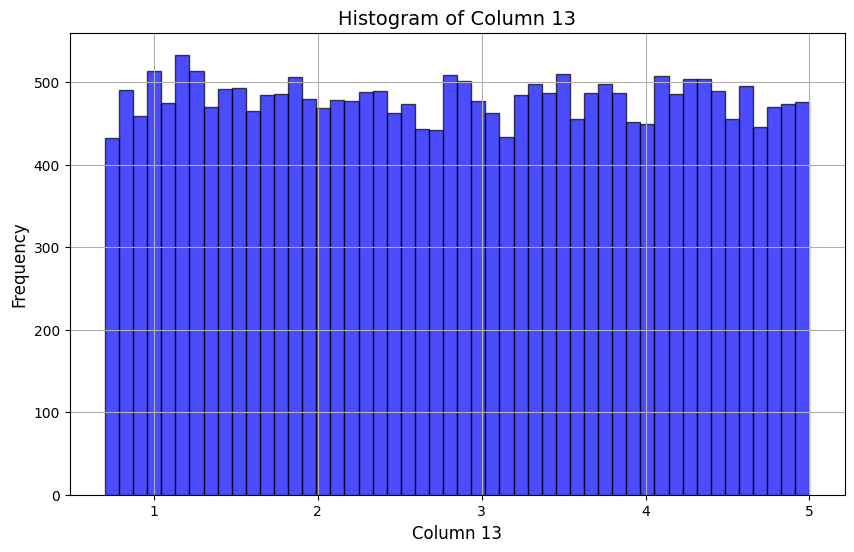

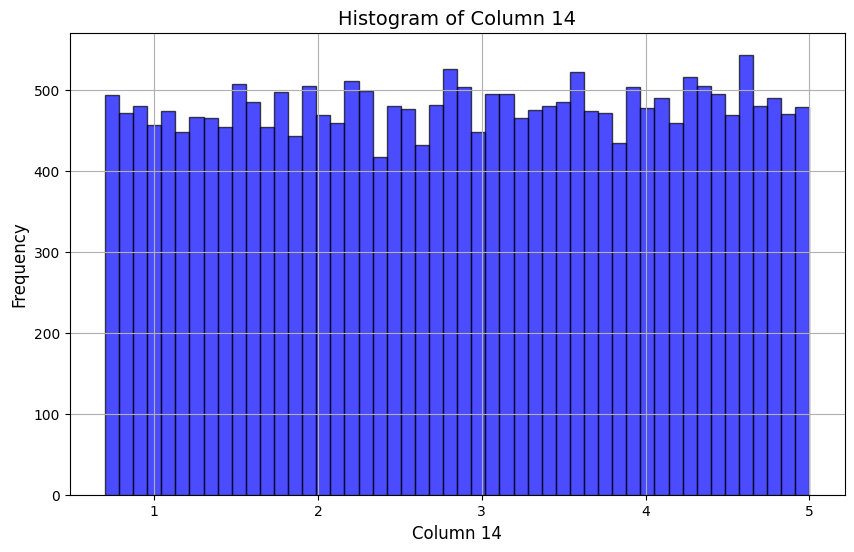

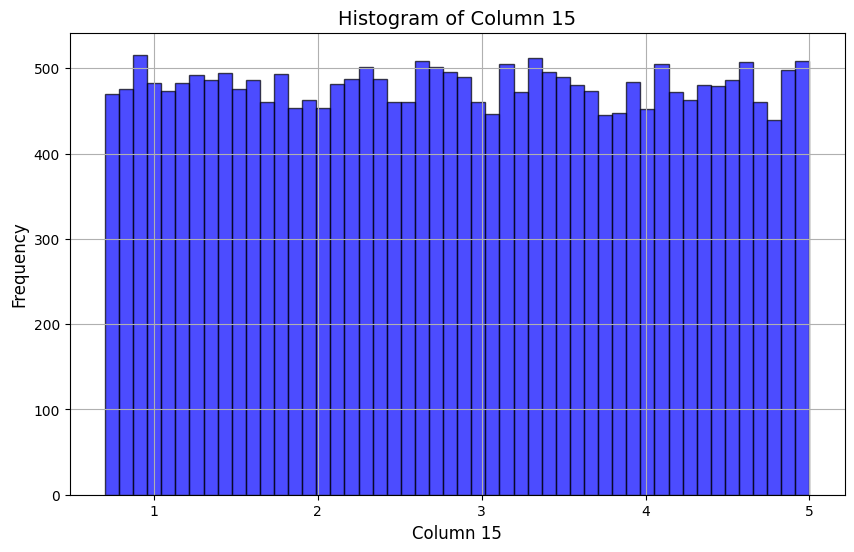

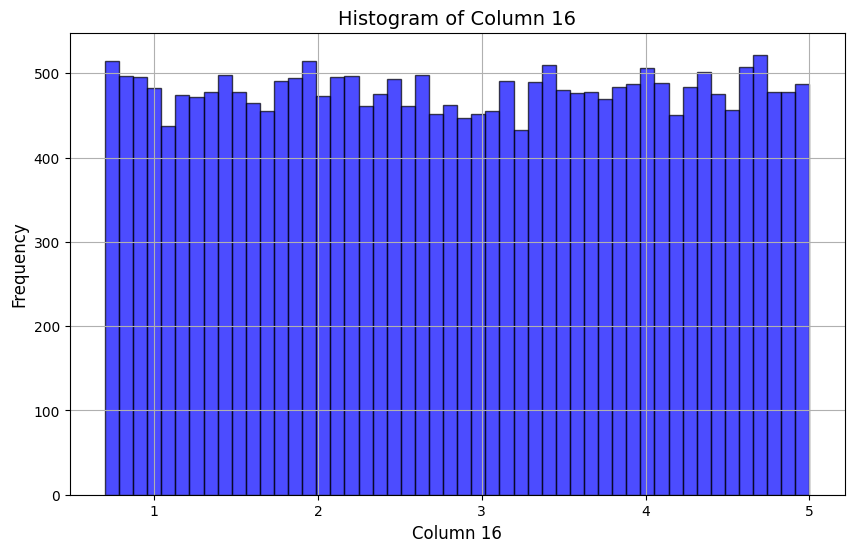

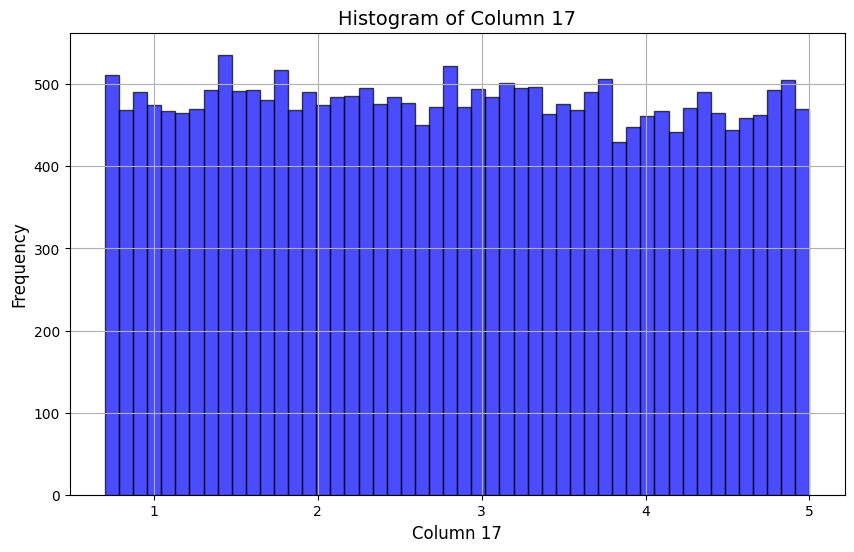

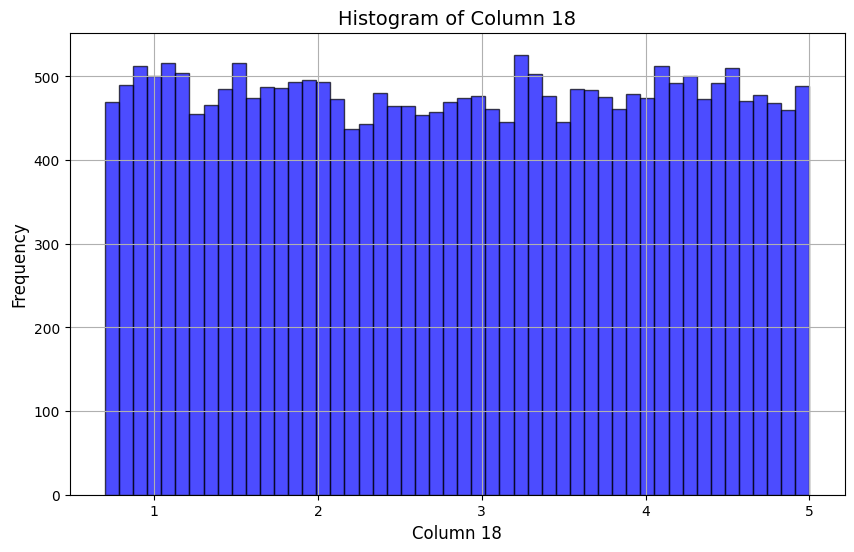

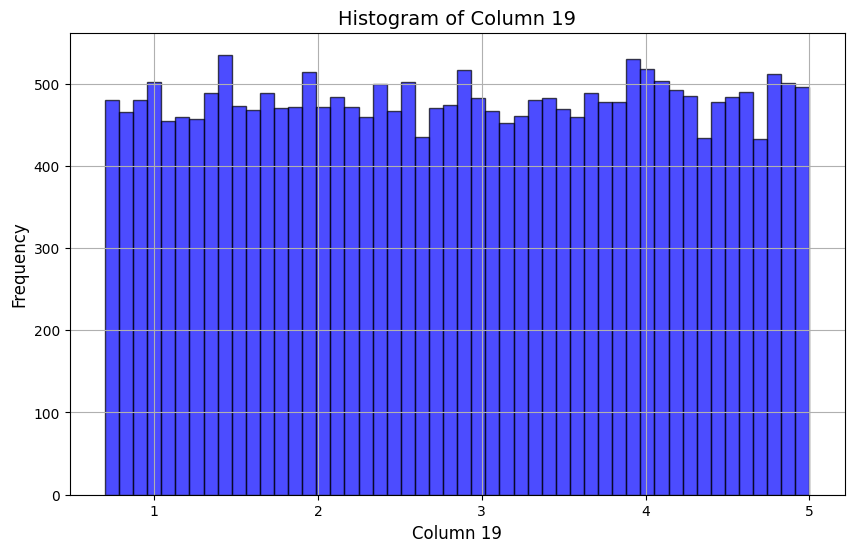

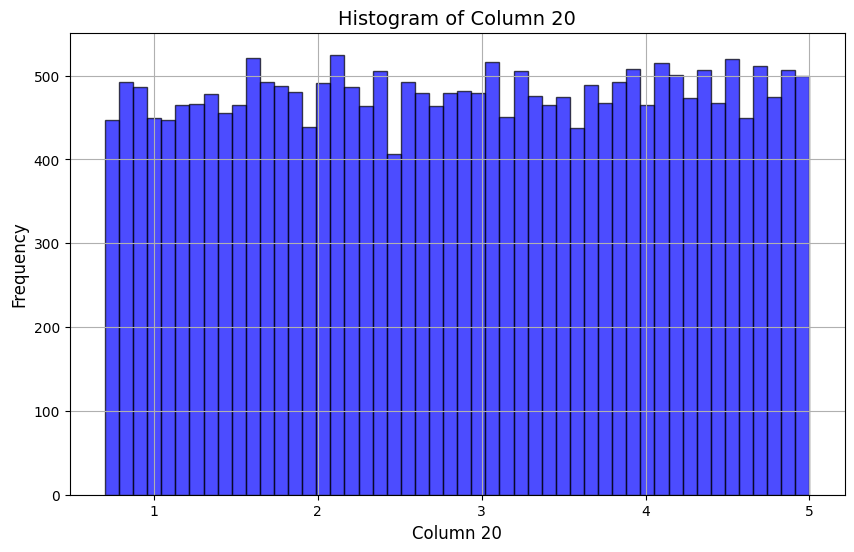

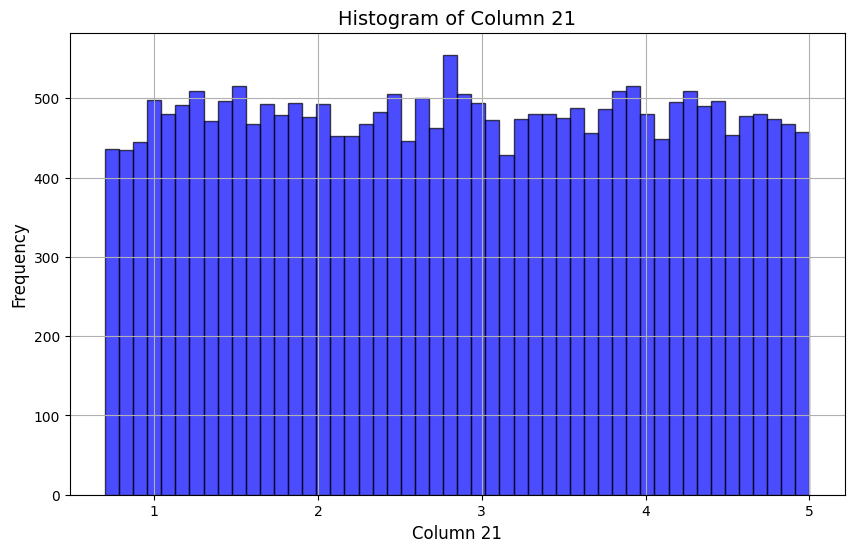

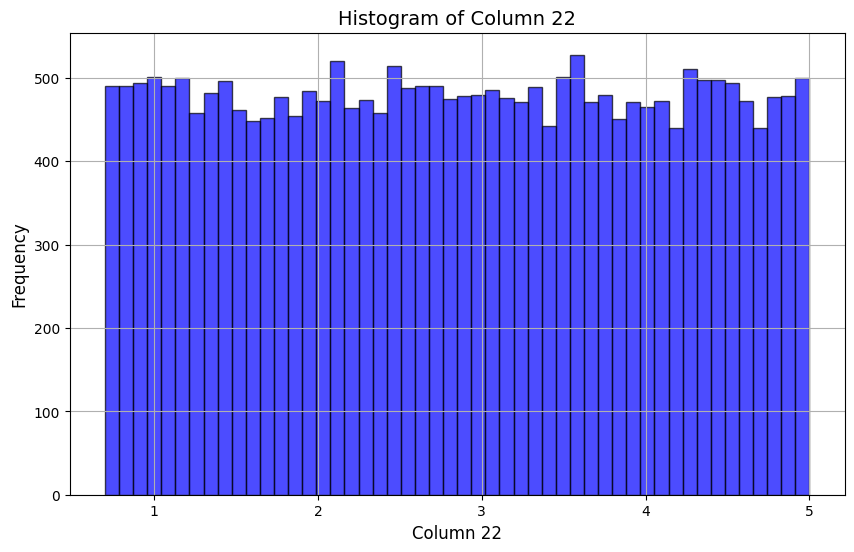

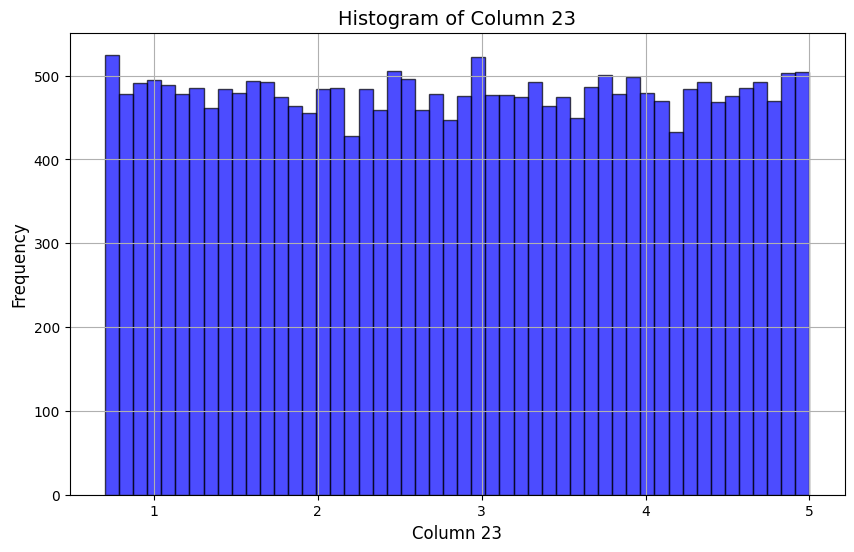

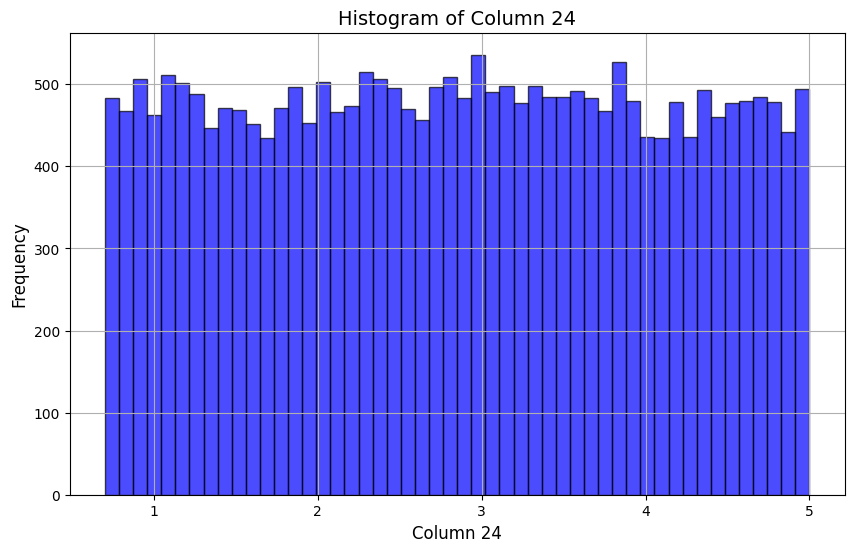

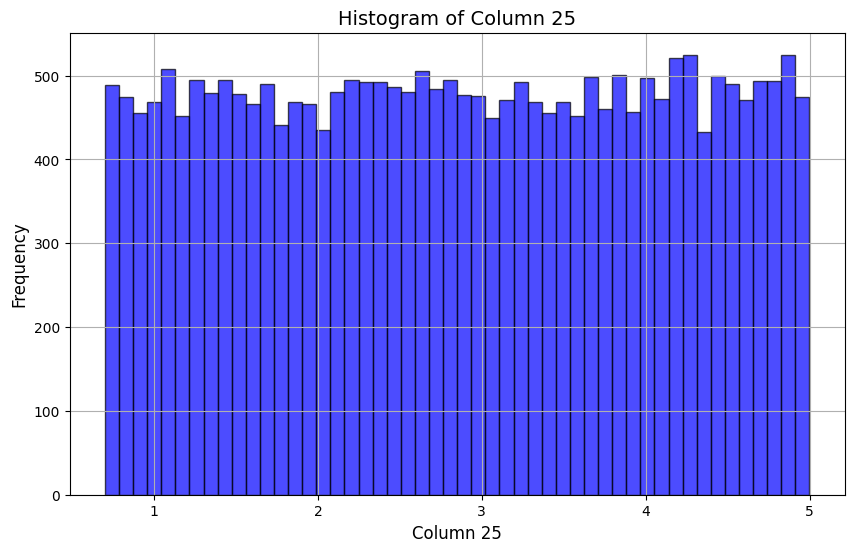

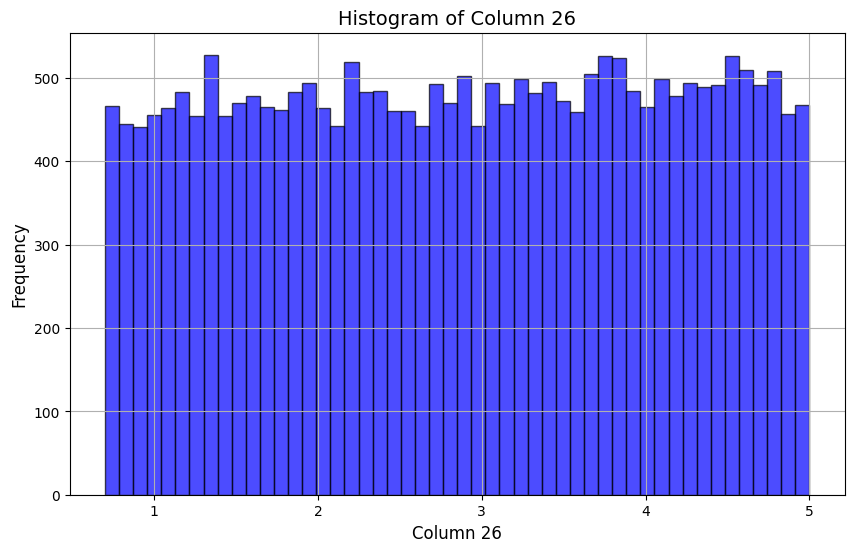

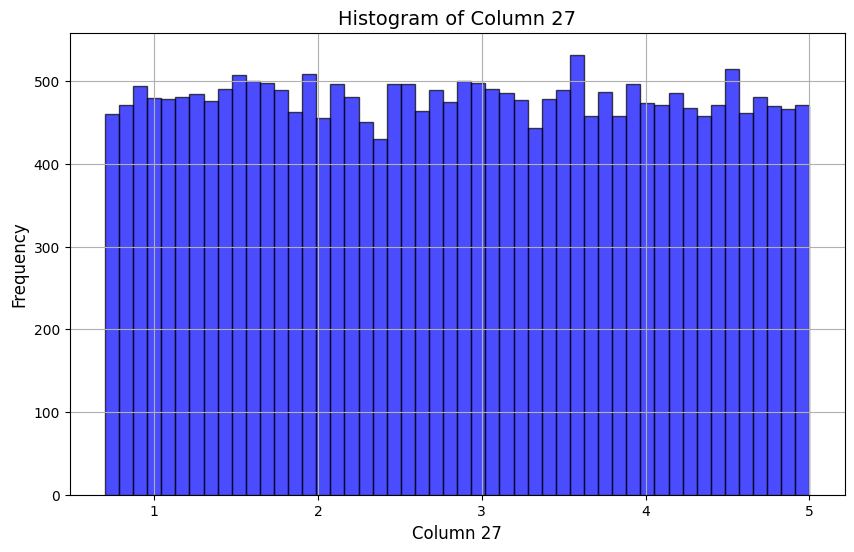

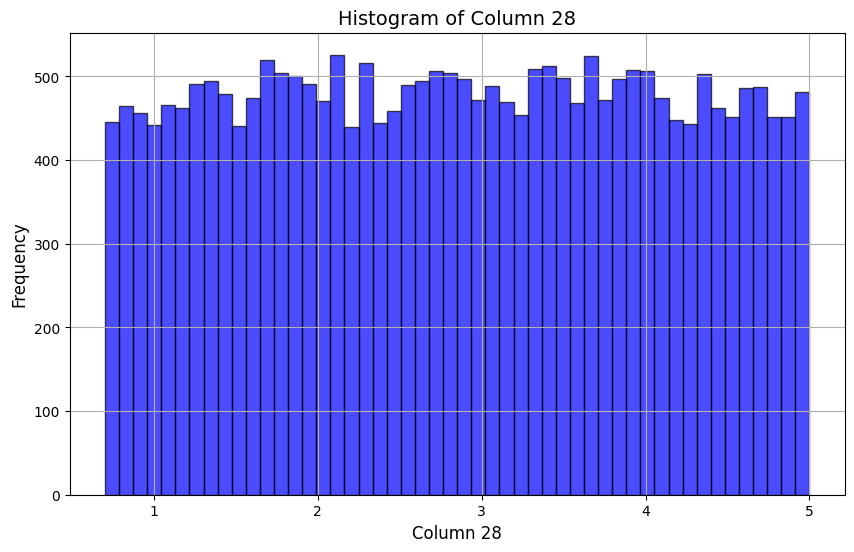

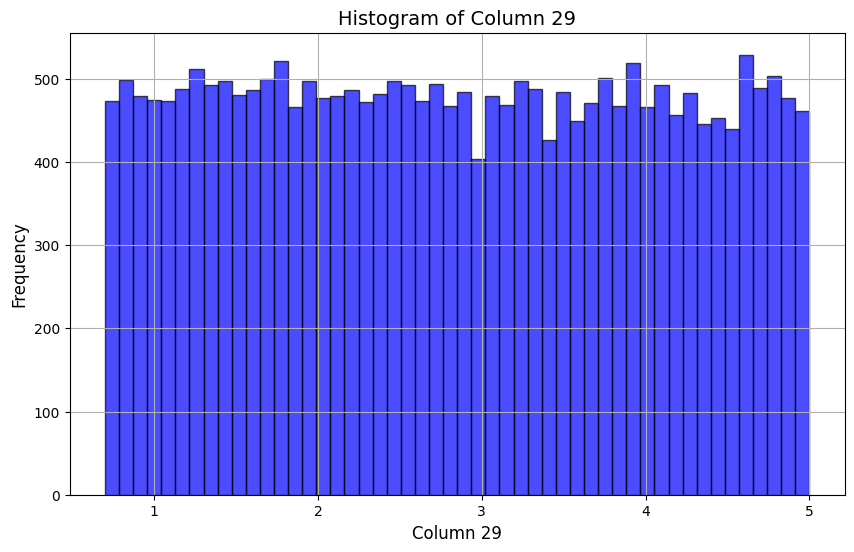

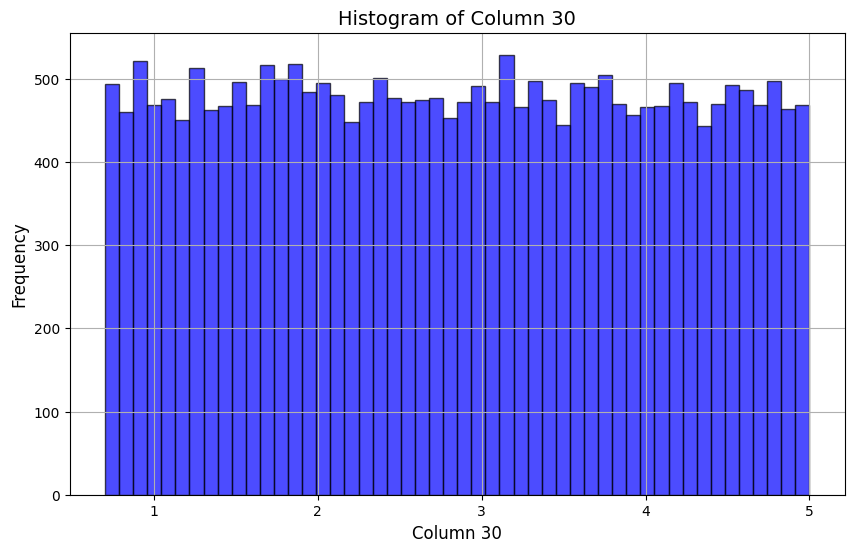

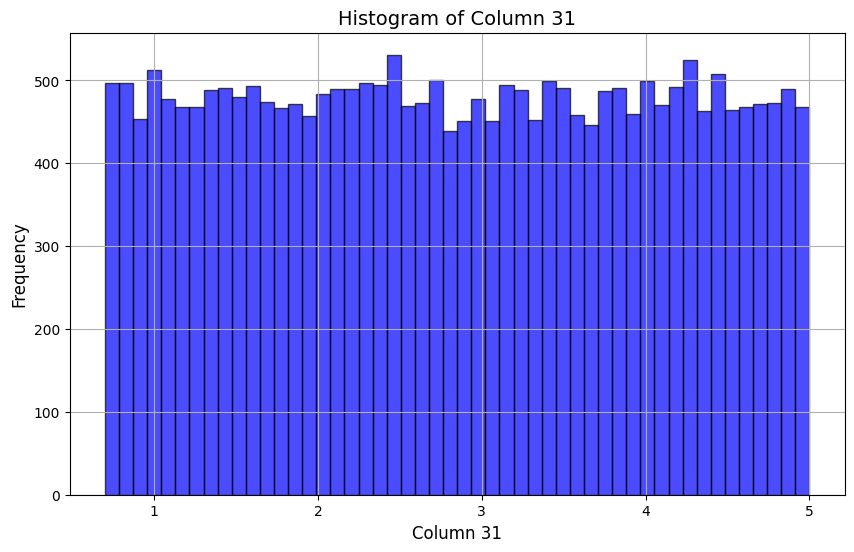

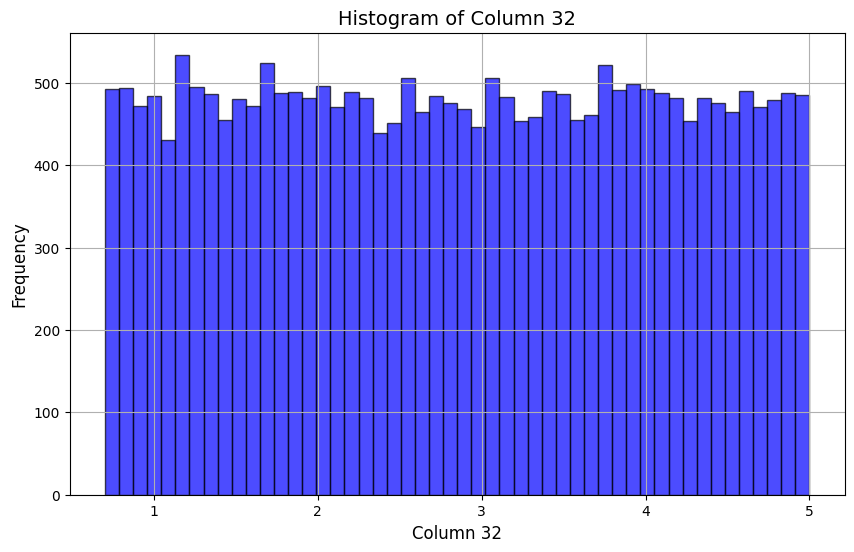

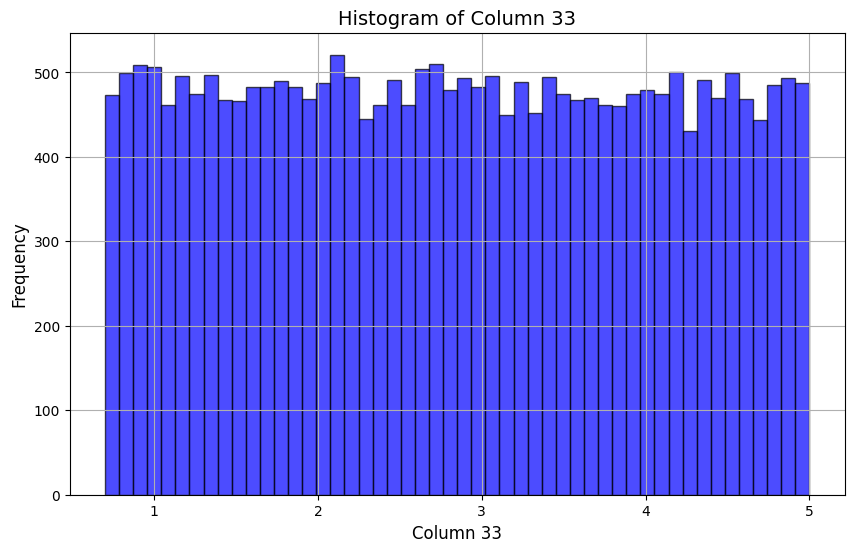

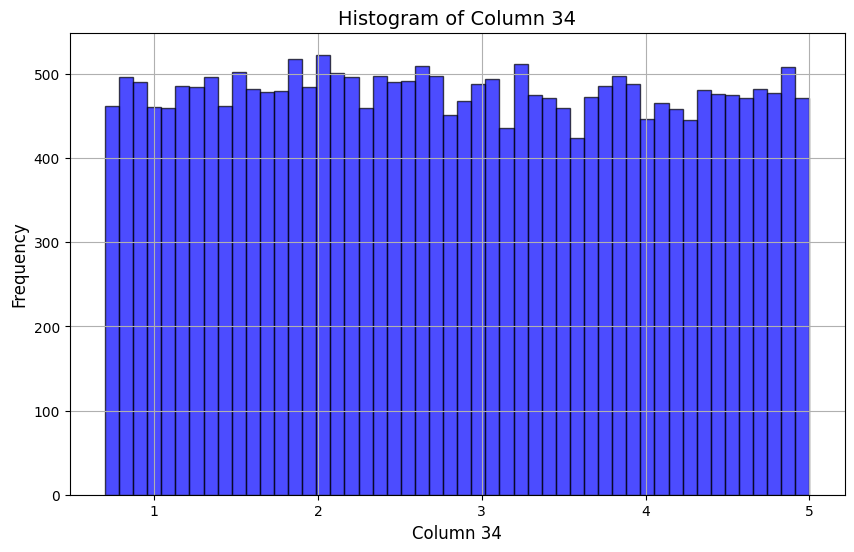

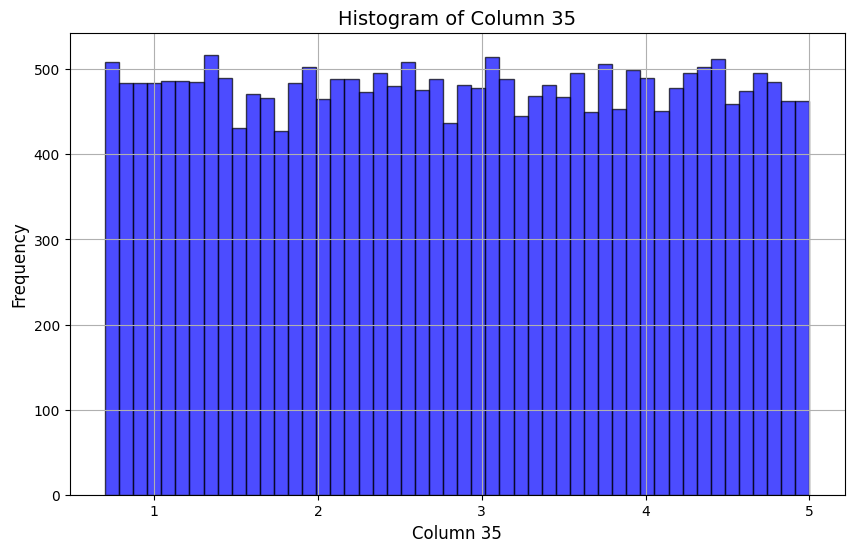

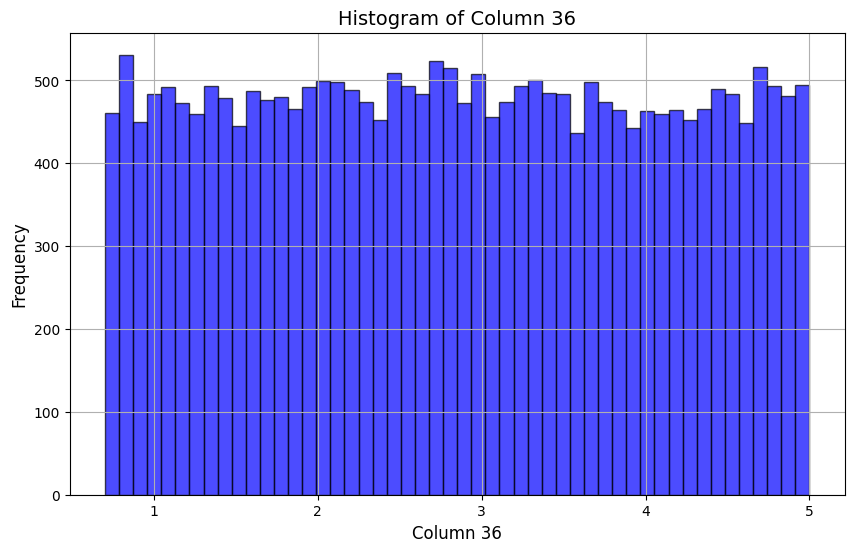

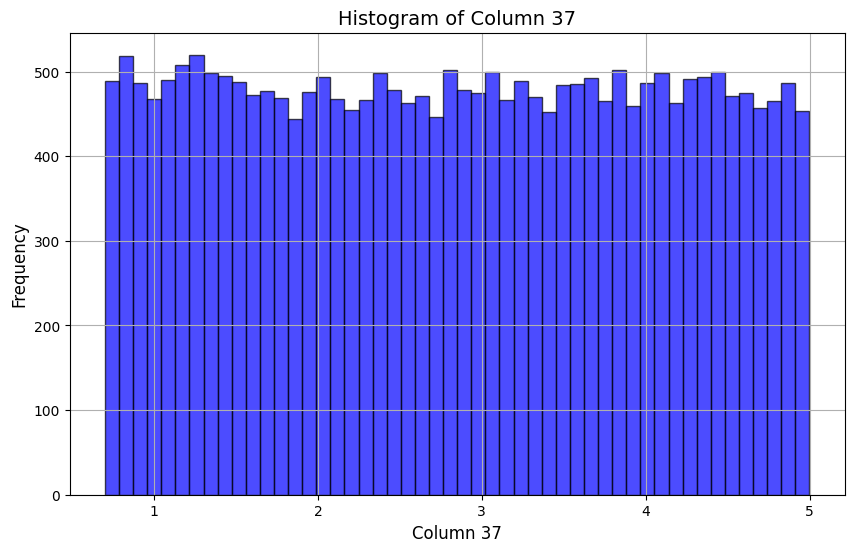

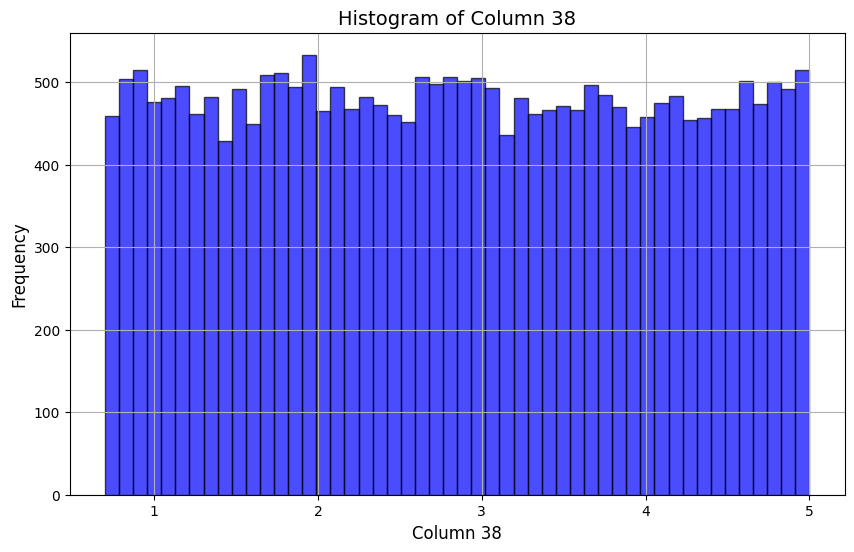

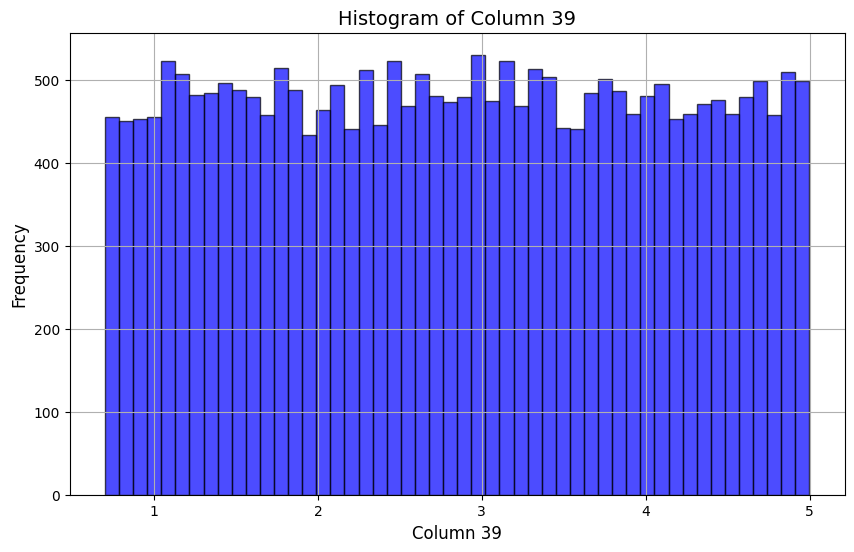

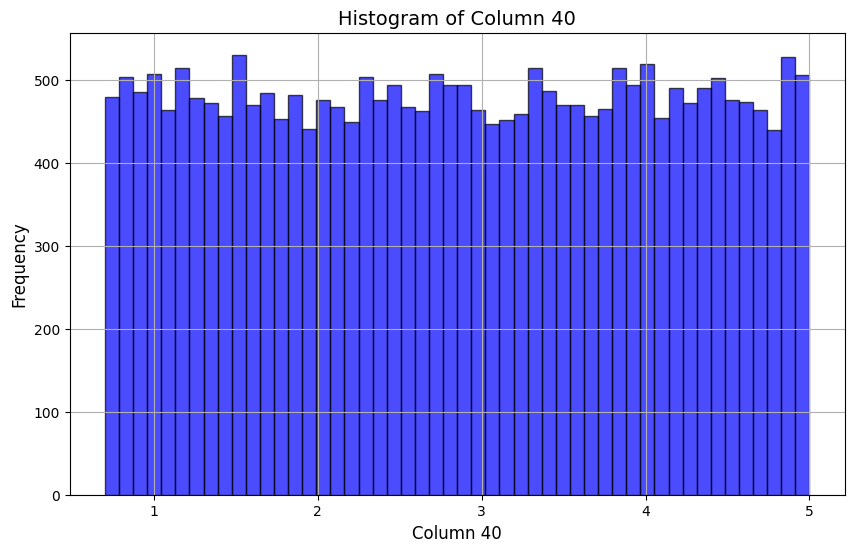

In [29]:

import matplotlib.pyplot as plt


# Plot histograms for each column
for column in data.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(data[column], bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f"Histogram of Column {column}", fontsize=14)
    plt.xlabel(f"Column {column}", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True)
    plt.show()


1st and 2nd column have gaussian curve so both are output.

In [30]:
X = data.iloc[:, 2:].values  # Features (columns 3 to 41)
y = data.iloc[:, :2].values  # outputs (columns 1 to 2)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#using scikit learn library for easy splitting the dataset for training and testing

In [32]:
# Normalize/scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define Optuna objective function
def objective(trial):
    # Hyperparameter search space
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 1000, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0),
    }

    # Train separate models for each target column
    models = []
    for i in range(y_train.shape[1]):
        model = XGBRegressor(**params)
        model.fit(X_train, y_train[:, i])
        models.append(model)

    # Make predictions for all target columns
    y_pred = np.column_stack([model.predict(X_test) for model in models])

    # Evaluate using Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    return mse


In [44]:

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=3600)  # 50 trials or 1 hour timeout

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train final models with best hyperparameters
best_params = study.best_params
final_models = []
for i in range(y_train.shape[1]):
    model = XGBRegressor(**best_params)
    model.fit(X_train, y_train[:, i])
    final_models.append(model)

# Make predictions with final models
y_pred = np.column_stack([model.predict(X_test) for model in final_models])

# Evaluate the final model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Test MSE: {mse:.4f}")
print(f"Final Test MAE: {mae:.4f}")

[I 2025-01-27 23:06:29,383] A new study created in memory with name: no-name-7349db92-03c8-4216-885e-fdcde4fd1b72
[I 2025-01-27 23:06:48,854] Trial 0 finished with value: 0.0019651278096565056 and parameters: {'n_estimators': 1753, 'learning_rate': 0.20780010892809522, 'max_depth': 13, 'subsample': 0.9077399701477324, 'colsample_bytree': 0.7871332889968472, 'lambda': 7.83556773416096, 'alpha': 3.092903503773615}. Best is trial 0 with value: 0.0019651278096565056.
[I 2025-01-27 23:07:03,212] Trial 1 finished with value: 0.0019389635365577257 and parameters: {'n_estimators': 1502, 'learning_rate': 0.1851264462299606, 'max_depth': 11, 'subsample': 0.6093140363112708, 'colsample_bytree': 0.7406953759462136, 'lambda': 9.144059729737142, 'alpha': 7.215346759111916}. Best is trial 1 with value: 0.0019389635365577257.
[I 2025-01-27 23:07:20,102] Trial 2 finished with value: 0.0015886564063228913 and parameters: {'n_estimators': 1557, 'learning_rate': 0.28770561625531915, 'max_depth': 5, 'subsa

Best hyperparameters: {'n_estimators': 1179, 'learning_rate': 0.10133184933371239, 'max_depth': 5, 'subsample': 0.7108238493957669, 'colsample_bytree': 0.5278407561968782, 'lambda': 8.698468359455862, 'alpha': 1.3902286680563503}
Final Test MSE: 0.0014
Final Test MAE: 0.0217
